In [1]:
#In the name of God

student_id = 401210923
student_name = "Navid Farahani"

print("your student id:", student_id)
print("your name:", student_name)
import numpy as np
import torch
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt


your student id: 401210923
your name: Navid Farahani


In [2]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
# Data
dir='drive/MyDrive/Q1 Materials/'
Data=pd.read_csv(dir+"BBBP.csv")
numpy_Data=np.array(Data)
number=numpy_Data[:,0]
name=numpy_Data[:,1]
p_np=numpy_Data[:,2]
smiles=numpy_Data[:,3]


In [64]:
# We use this function for changing the device
def to_device(data, device):
    # for every batch, we pass the data to the current device.
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


# We use this class for passing the data and model to the device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        #For every batch, we pass it to the current device.
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Selecting the current device
if torch.cuda.is_available():
      device=torch.device('cuda')
else:
      device=torch.device('cpu')

print("The device is:",device)


The device is: cuda


**قسمت آ**

For the smiles, the maximum length is 400.0
For the smiles, the minimum length is 3.0
For the smiles, the mean length is 51.47414634146342
For the smiles, the standard deviation of lengthes is 30.61318964709212


Text(0, 0.5, 'Frequency of chemical compounds')

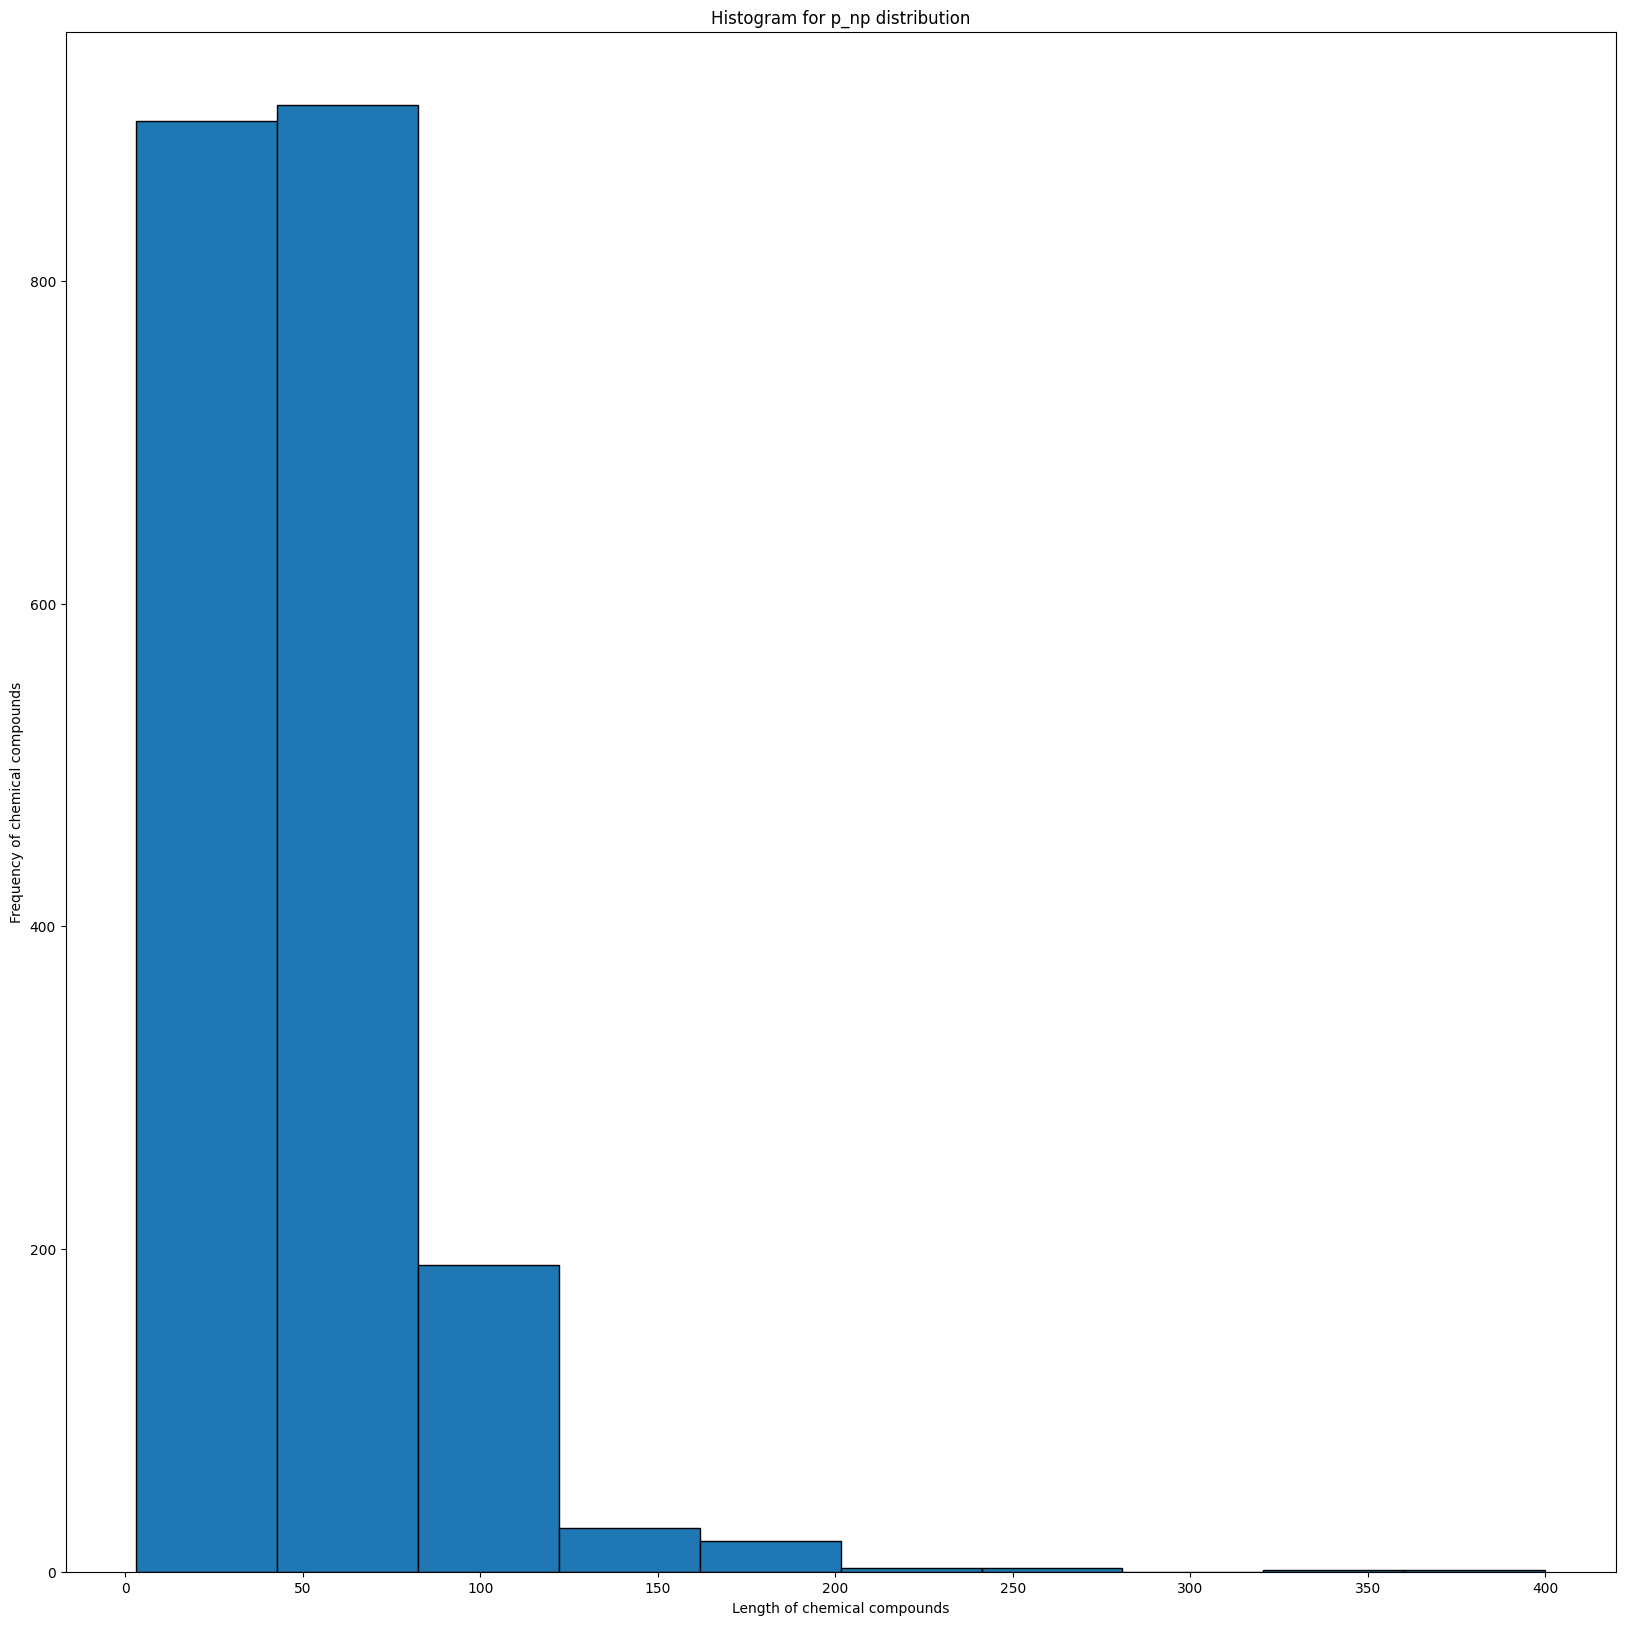

In [65]:


lens_for_smiles=np.zeros(len(smiles))

for i in range(len(smiles)):
    lens_for_smiles[i]=len(smiles[i])

the_mean=np.mean(lens_for_smiles)
the_std=np.std(lens_for_smiles)
the_min=np.min(lens_for_smiles)
the_max=np.max(lens_for_smiles)

print("For the smiles, the maximum length is",the_max)
print("For the smiles, the minimum length is",the_min)
print("For the smiles, the mean length is",the_mean)
print("For the smiles, the standard deviation of lengthes is",the_std)

plt.figure(figsize=(20,20))
plt.hist(lens_for_smiles,edgecolor="black")
plt.title("Histogram for p_np distribution")
plt.xlabel("Length of chemical compounds")
plt.ylabel("Frequency of chemical compounds")



همانطور که از نمودار فوق مشخص است، اکثر این فرمولهای شیمیایی دارای طول کم هستند و برای طول بین 260 تا 322 هیچ گونه فرمول شیمیایی وجود ندارد. اکنون میخواهیم این منحنی ها را به صورت جداگانه در چندین بازه رسم کنیم. تعداد بازه ها طبق کد زیر، 10 است.

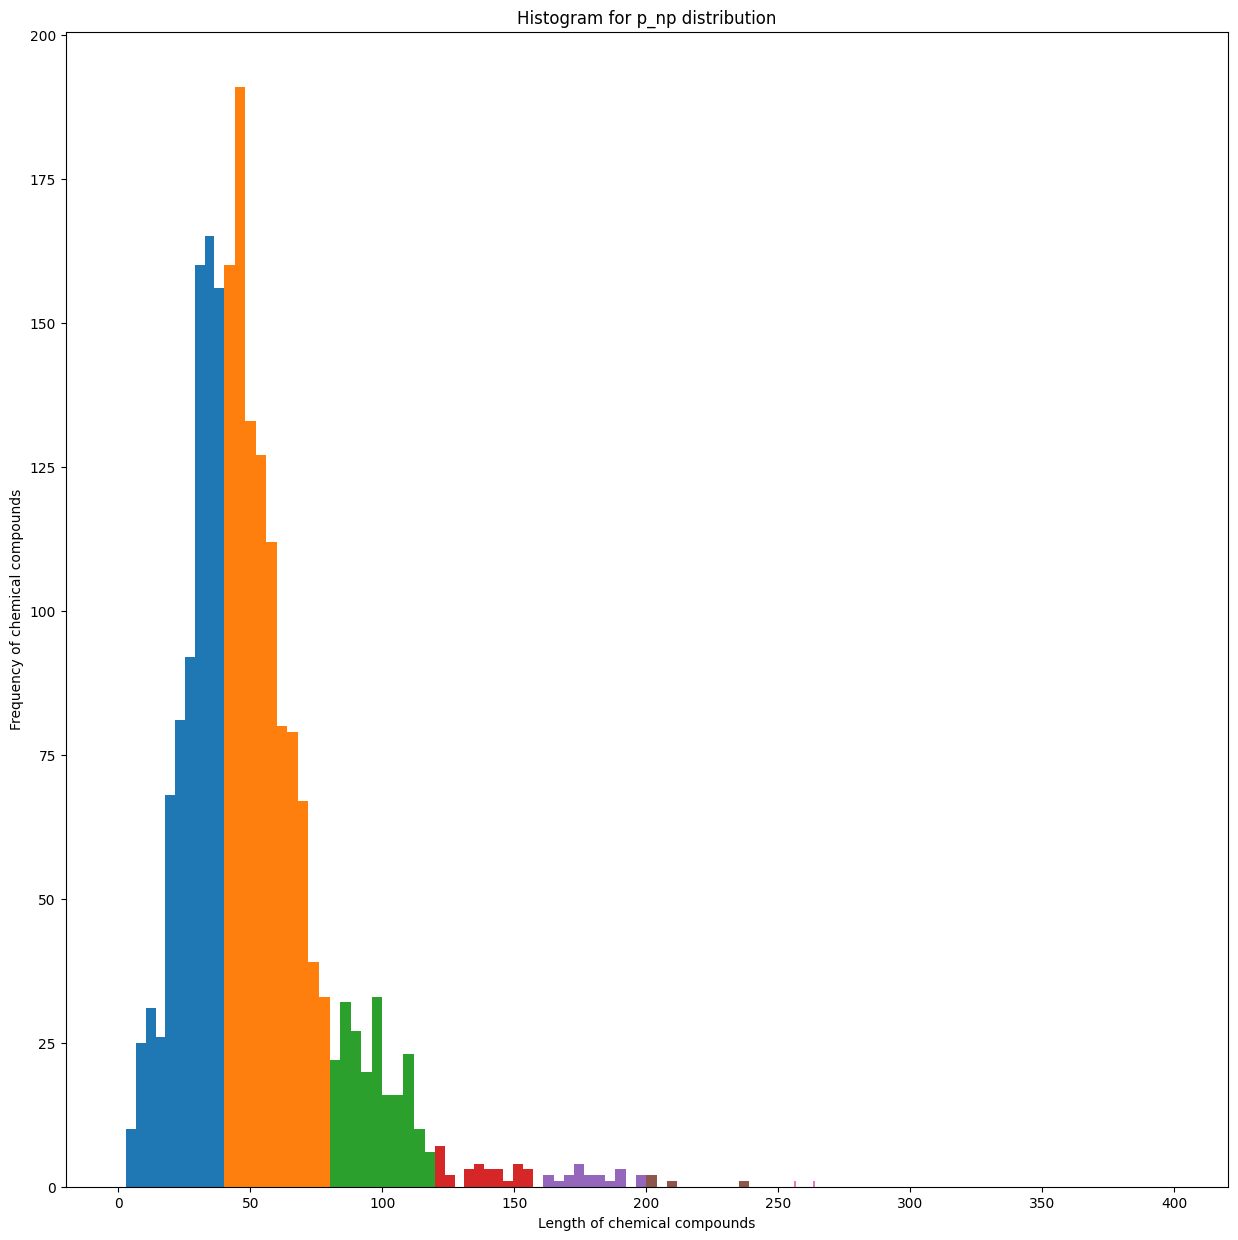

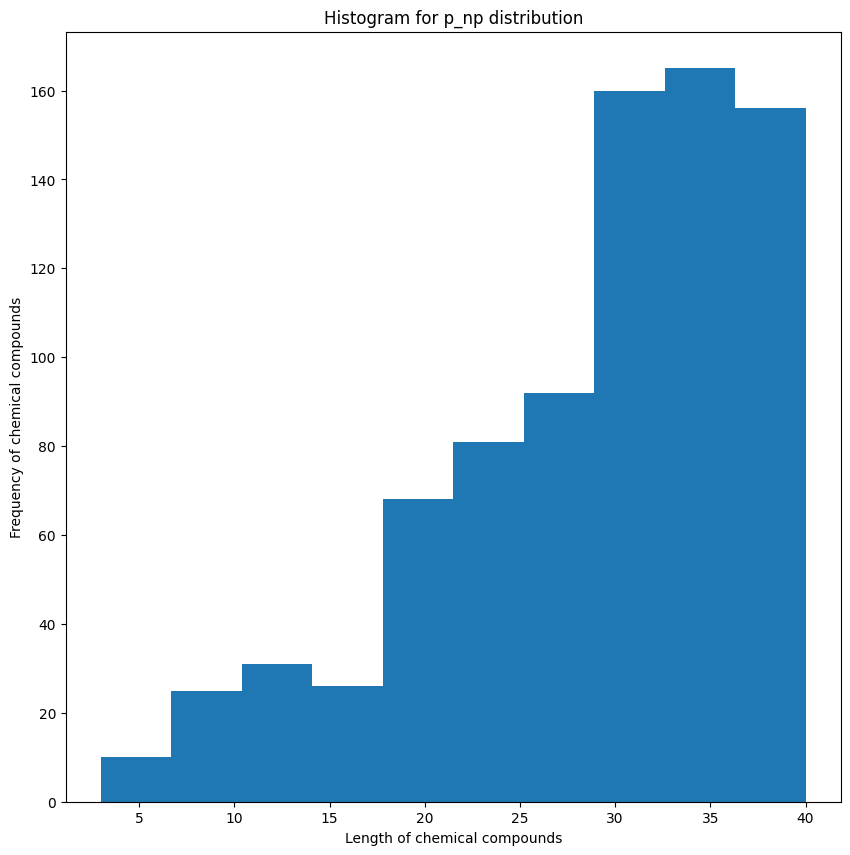

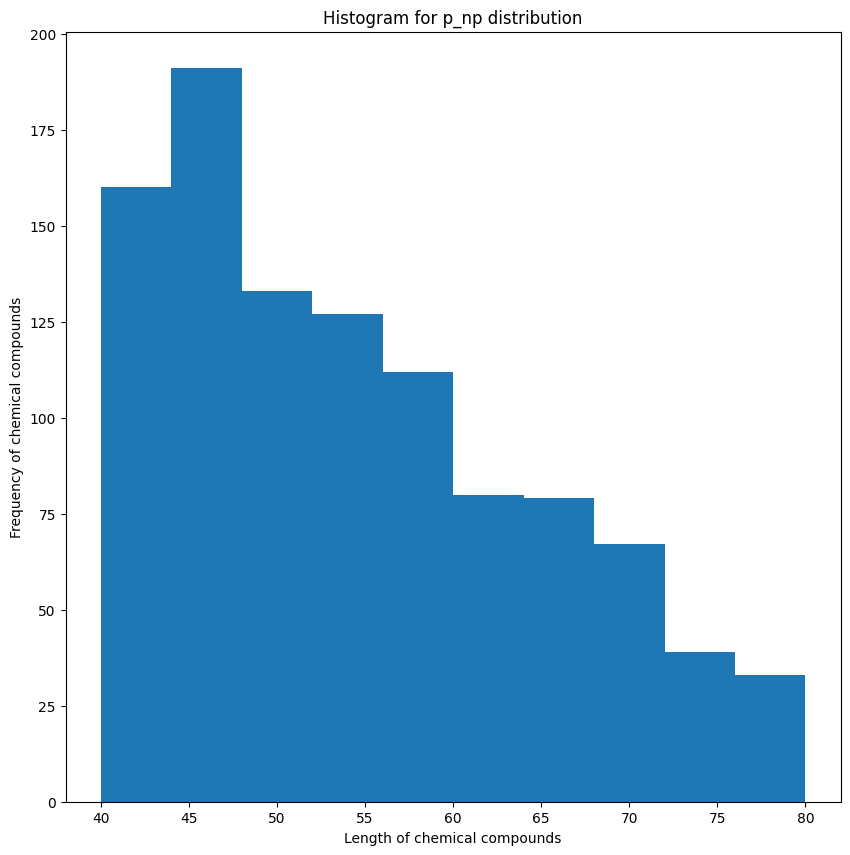

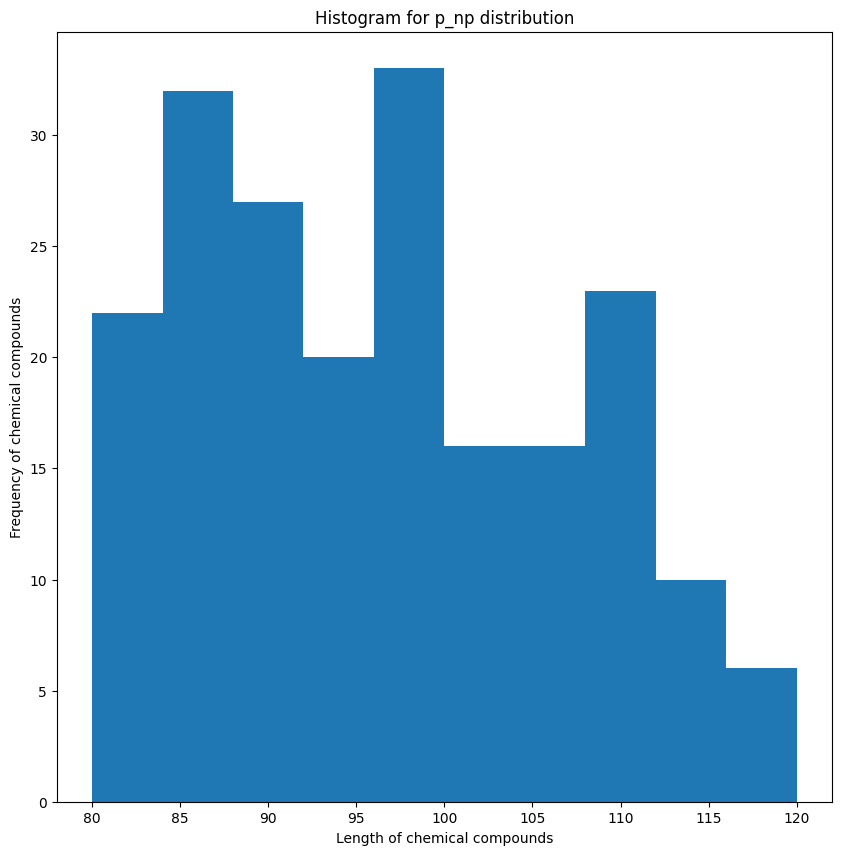

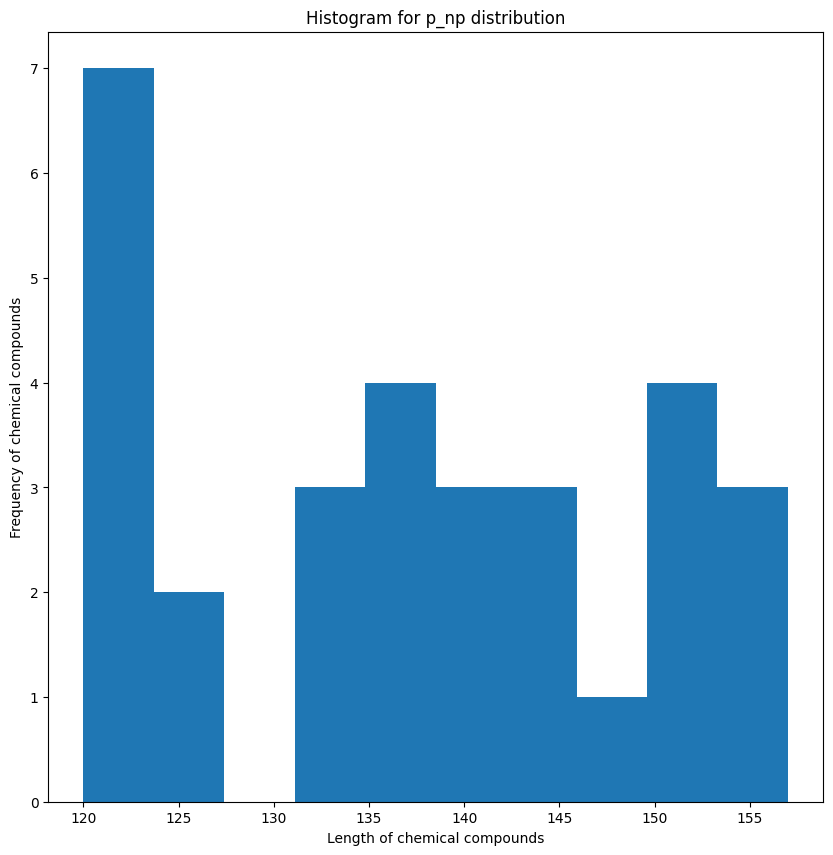

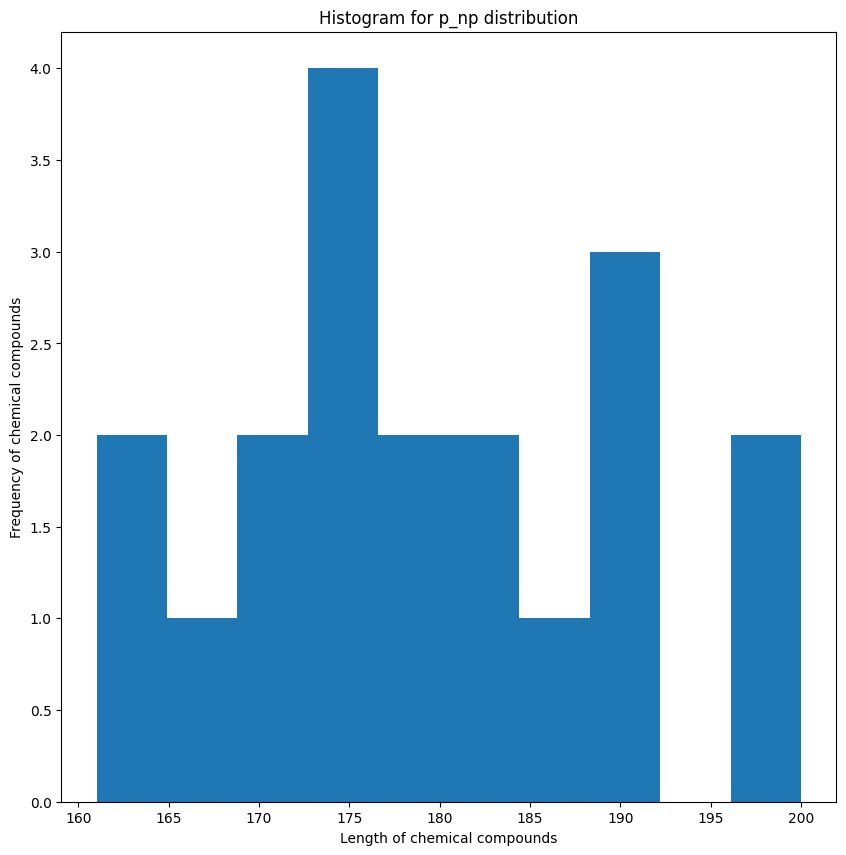

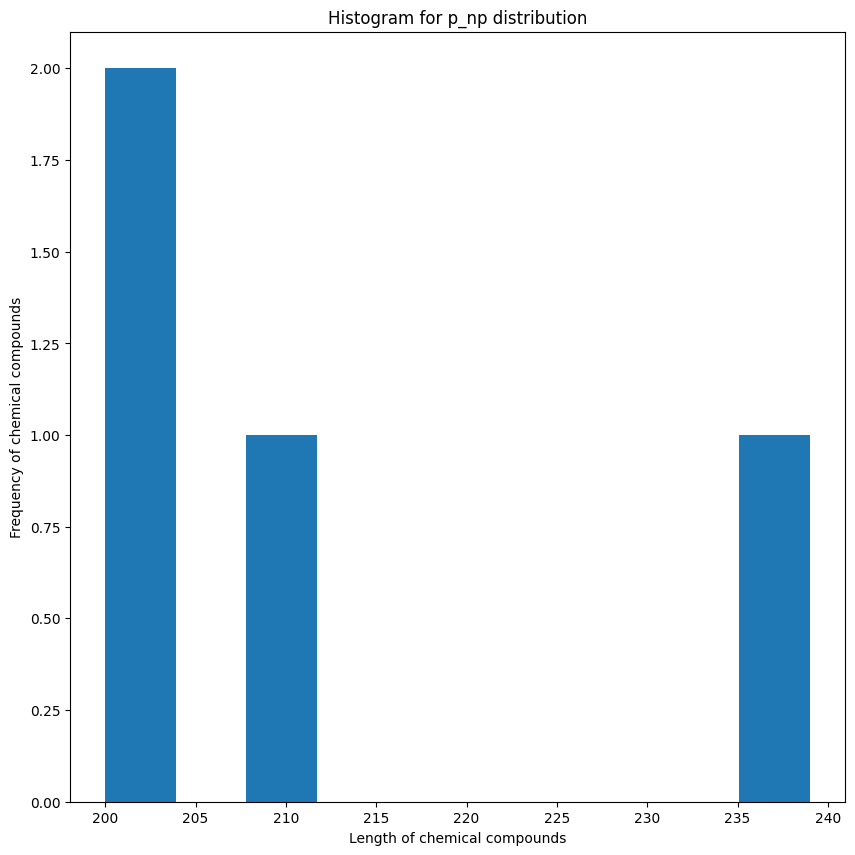

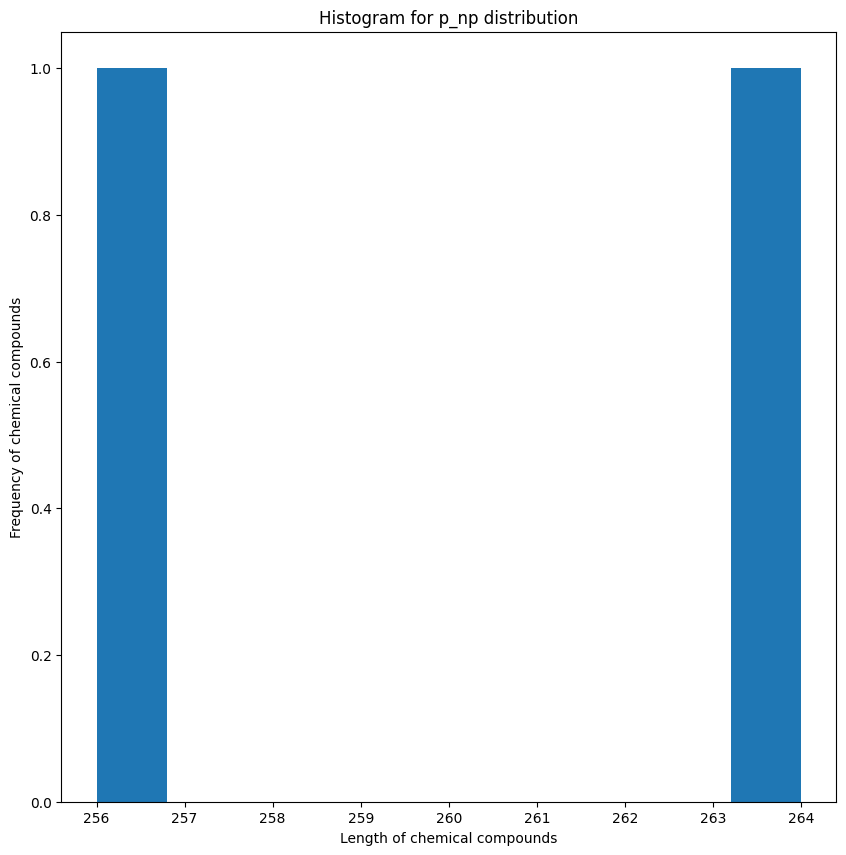

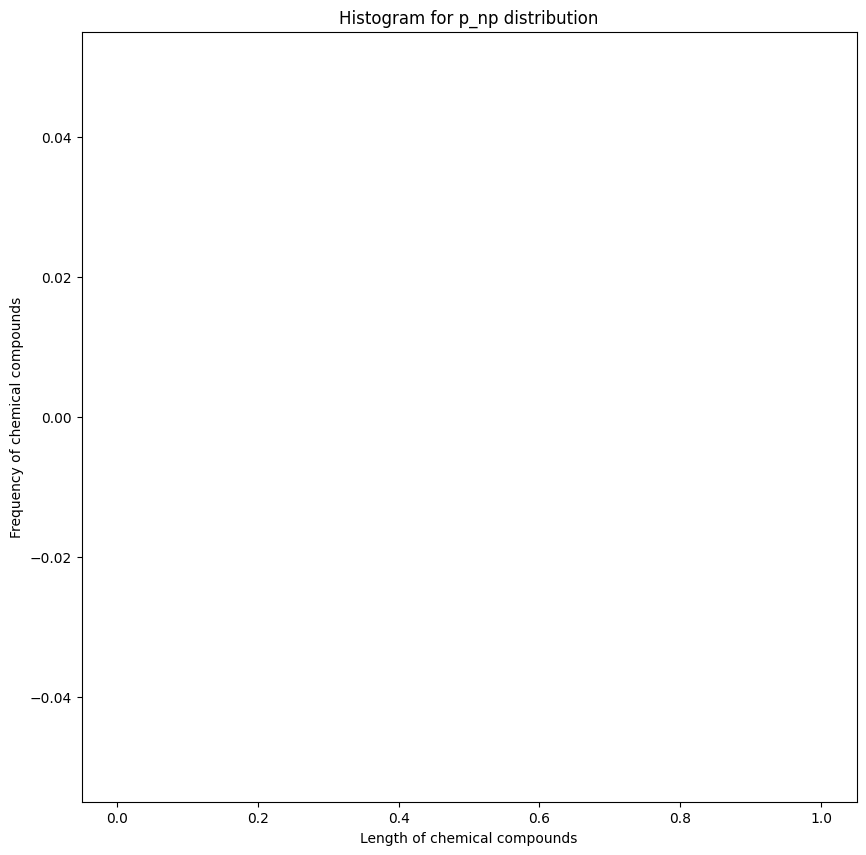

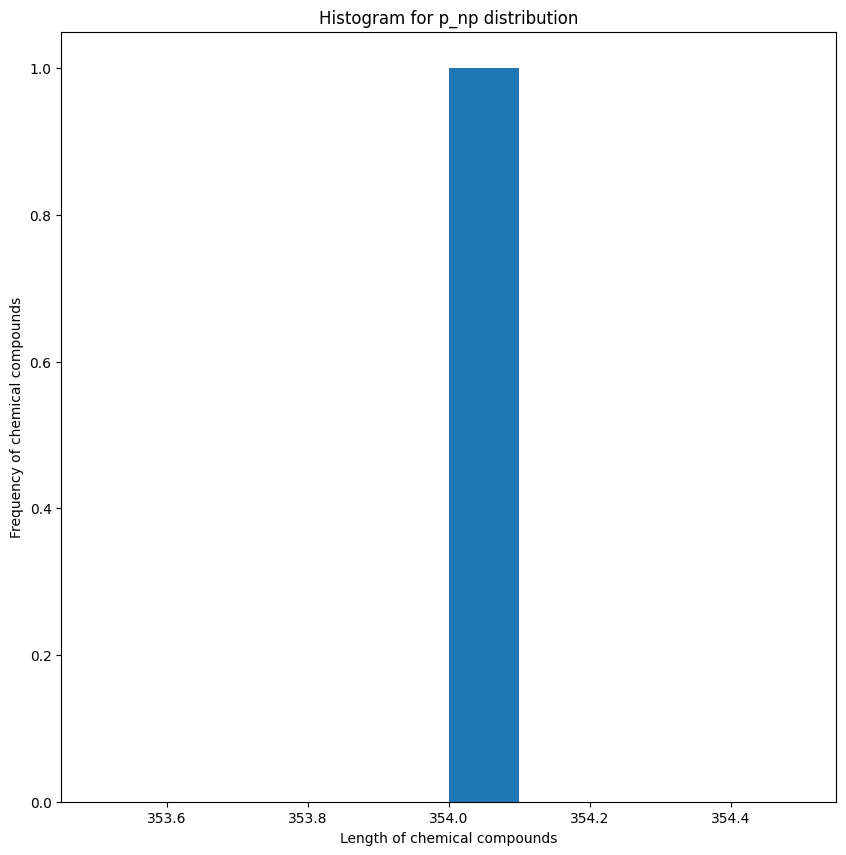

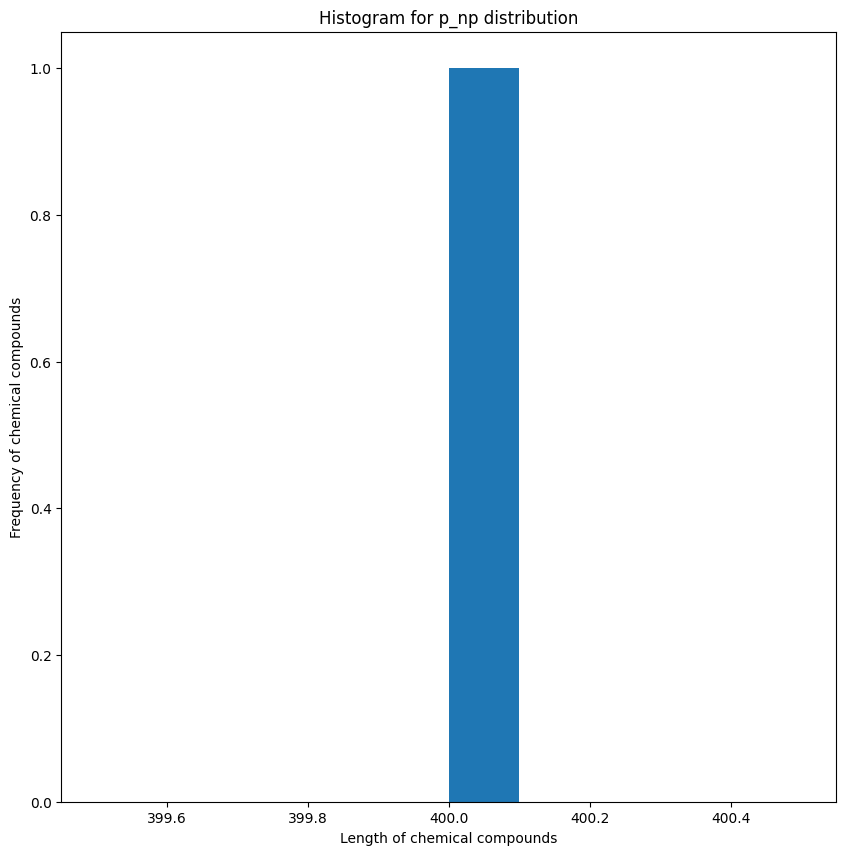

In [66]:


num_steps=10
step=400//num_steps
first_clipper=0
plt.figure(figsize=(15,15))
for n in range(num_steps):
    clipped_lens_for_smiles=[]
    second_clipper=first_clipper+step
    for i in range(len(smiles)):
        if (lens_for_smiles[i]<=second_clipper and lens_for_smiles[i]>=first_clipper ):
            clipped_lens_for_smiles.append(lens_for_smiles[i])

    plt.hist(clipped_lens_for_smiles)
    plt.title("Histogram for p_np distribution")
    plt.xlabel("Length of chemical compounds")
    plt.ylabel("Frequency of chemical compounds")

    first_clipper=second_clipper


first_clipper=0
for n in range(num_steps):
    clipped_lens_for_smiles=[]
    second_clipper=first_clipper+step
    for i in range(len(smiles)):
        if (lens_for_smiles[i]<=second_clipper and lens_for_smiles[i]>=first_clipper ):
            clipped_lens_for_smiles.append(lens_for_smiles[i])


    plt.figure(figsize=(10,10))
    plt.hist(clipped_lens_for_smiles)
    plt.title("Histogram for p_np distribution")
    plt.xlabel("Length of chemical compounds")
    plt.ylabel("Frequency of chemical compounds")

    first_clipper=second_clipper





In [67]:

############# Tokenizing the characters

# First we want to see that how many unique data do we have for these smiles to calculation of the frequency of them.
all_unique_data=[]
for k in range(len(smiles)):

    symbols = []
    current_symbol = smiles[k][0]
    i=1
    # For every smile, we want to split it to some tokens,
    # Note that '[',']','(',')','=','0','1','2','3','4','5','6','7','8','9',"'\'",'/' are considered a token according to
    # the question, and if we have '@', we should consider after and before @ one token.

    while i < len(smiles[k]):
        char = smiles[k][i]# a character like C or c or N or H or etc.
        # We know that if a character is capital, we should consider it and after that as a token (Like Br)
        # Also, if the character is '[',']','(',')','=','0','1','2','3','4','5','6','7','8','9',"'\'",'/' , it is a token.

        if char.isupper() or char in ['[',']','(',')','=','0','1','2','3','4','5','6','7','8','9',"'\'",'/']:
            symbols.append(current_symbol)
            current_symbol = char
            # if we have '@', we should consider after and before @ one token like C@H
        elif char == '@':
            current_symbol += char + smiles[k][i+1:i+2]
            i=i+2
        else:
            current_symbol += char
        i=i+1
    symbols.append(current_symbol)

    # set variable in python are unique, so we can use set for making the characters unique!

    unique_data = set()

    for item in symbols:
        unique_data.add(item)

    unique_data = list(unique_data)

    all_unique_data.append(unique_data)


# We could find all data and we constructed a matrix for them, and we will convert them to vectors later
# But, if we want to convert all the data to vectors, we need to know how much unique data do we have
# Because we want to change them to one-hot variables
# and the number of one-hot variables is equal to the unique characters.

unique_set = set(value for sublist in all_unique_data for value in sublist)

# Convert the set back to a sorted list to preserve order
characters = sorted(list(unique_set))

print(characters)

print("We have ",len(characters)," Data, so we should consider",len(characters),"One-hot vectors")

# We want to find the longest length for the smiles, because if we find it, we can use padding for all the data
# and construct a 3 D tensor data for all the smiles. This tensor will be explained later.
lens=[]
for i in range(len(all_unique_data)):
  lens.append(len(all_unique_data[i]))

the_max_length=np.max(lens)
print("The longest smile has",the_max_length,"characters")

['(', '(\\', '(c', '(cc', '(ccc', '(cccc', '(ccccc', '(cccn', '(ccn', '(cnc', '(csc', '(n', '(nc', '(ncc', '(nccc', '(ncnc', '(nn', '(o', '(oc', '(on', '(sc', '(scc', ')', ')\\', ')\\c', ')c', ')c%', ')cc', ')ccc', ')cccc', ')ccn', ')cn', ')n', ')nc', ')ncc', ')ncn', ')nn', ')noc', ')o', ')occ', ')on', ')onc', ')sc', ')scc', '/', '/%', '/c', '0', '1', '1%', '1.', '1\\', '1c', '1cc', '1ccc', '1cccc', '1ccccc', '1cccn', '1cccnc', '1ccnc', '1ccncc', '1cn', '1cnc', '1cncc', '1cnccn', '1cncn', '1cnn', '1csc', '1n', '1nc', '1ncc', '1nccc', '1ncccc', '1ncccn', '1nccs', '1ncn', '1ncnc', '1ncsc', '1nnc', '1nncc', '1nnnc', '1noc', '1oc', '1occc', '1onc', '1sc', '1scc', '2', '2+', '2-', '2.', '2\\', '2c', '2c%', '2cc', '2ccc', '2cccc', '2ccccc', '2ccccn', '2cccnc', '2ccnc', '2ccnn', '2cnc', '2cncn', '2csc', '2cscc', '2n', '2nc', '2nccc', '2ncccc', '2ncccn', '2ncn', '2noc', '2occc', '2sc', '2sccc', '3', '3+', '3.', '3c', '3cc', '3ccc', '3cccc', '3ccccc', '3ccccn', '3cccnc', '3ccnc', '3ccncc', '3cc

In [68]:
####### Determining the frequency of tokens

# Now we have the unique data, we can find the frequency of all of them by using this code again
# but this time, we store the frequency in "frequency" variable.

all_unique_data=[]
frequency=np.zeros(len(characters))
for k in range(len(smiles)):

    symbols = []
    current_symbol = smiles[k][0]
    i = 1
    while i < len(smiles[k]):
        char = smiles[k][i]
        if char.isupper() or char in ['[',']','(',')','=','0','1','2','3','4','5','6','7','8','9',"'\'",'/']:
            symbols.append(current_symbol)
            current_symbol = char
        elif char == '@':
            current_symbol += char + smiles[k][i+1:i+2]
            i += 2
        else:
            current_symbol += char
        i += 1

        for index_char in range(len(characters)):
          if (current_symbol==characters[index_char]):
            frequency[index_char]=frequency[index_char]+1
    symbols.append(current_symbol)


    unique_data = set()

    for item in symbols:
        unique_data.add(item)

    unique_data = list(unique_data)

    all_unique_data.append(unique_data)


unique_set = set(value for sublist in all_unique_data for value in sublist)


print("The frequency of the tokens is\n",frequency)



The frequency of the tokens is
 [1.0386e+04 2.5000e+01 3.6100e+02 1.4500e+02 4.3000e+01 6.0000e+00
 3.0000e+00 1.0000e+00 2.0000e+00 4.0000e+00 4.0000e+00 4.2000e+01
 2.1000e+01 7.0000e+00 3.0000e+00 1.0000e+00 1.0000e+00 6.0000e+00
 2.0000e+00 2.0000e+00 3.0000e+00 2.0000e+00 1.0491e+04 5.9000e+01
 7.0000e+00 1.0190e+03 4.0000e+00 2.5500e+02 8.3000e+01 3.3000e+01
 4.0000e+00 4.0000e+00 6.8000e+01 2.2000e+01 5.0000e+00 1.0000e+00
 5.0000e+00 1.0000e+00 7.0000e+00 2.0000e+00 3.0000e+00 1.0000e+00
 2.0000e+00 1.0000e+00 1.8400e+02 2.0000e+00 2.3000e+01 8.0000e+00
 4.0550e+03 1.0000e+00 2.0000e+00 1.8000e+01 4.1800e+02 3.0600e+02
 2.6300e+02 1.2000e+02 7.8000e+01 4.0000e+00 3.0000e+00 4.0000e+00
 1.0000e+00 1.9000e+01 1.3000e+01 3.0000e+00 2.0000e+00 2.0000e+00
 1.0000e+00 6.0000e+00 4.8000e+01 3.1000e+01 1.0000e+01 3.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 4.0000e+00 1.0000e+00 1.0000e+00
 4.0000e+00 1.0000e+00 5.0000e+00 5.0000e+00 7.0000e+00 1.0000e+00
 8.0000e+00 1.0000e+01 4.0000e

**قسمت ب**

Text(0.5, 1.0, 'Histogram of lengthes of different tokens')

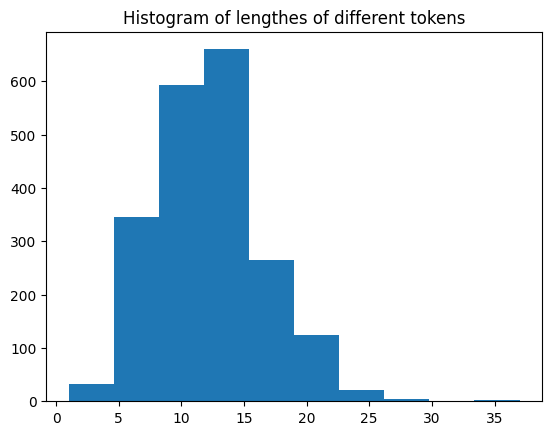

In [69]:

################

# To convert the tokens to vector, we loop on all the smiles and another loop on all the tokens in one smile
# then we consider one token of a smile and compare them with all unique characters by
# using the code for k in range(len(characters)),
# then we set the related variable of the vector to one and all other variables of the vectors will be zero.

vectorized_data=[]
lengthes=[]
for i in range(len(all_unique_data)):
    #all_tokens=np.zeros((len(all_unique_data[i]),len(characters)))
    all_tokens=np.zeros((the_max_length,len(characters)))
    vectorized_data.append(all_tokens)
    lengthes.append(len(all_unique_data[i]))
    for j in range(len(all_unique_data[i])):

        for k in range(len(characters)):
            if (characters[k]==all_unique_data[i][j]):
                vectorized_data[i][j][k]=1

plt.hist(lengthes)
plt.title("Histogram of lengthes of different tokens")

In [70]:

# Now we have the data as a matrix, so we can convert it to a numpy array to use it
# But we should note that the data for MLP must be reshaped. In other words, for every smile we should have
# a vector, but in LSTM we will change this.


reshaped_data = np.reshape(vectorized_data, (len(smiles), the_max_length * len(characters)))


labels = p_np
# use train_test_split function to split the data to train and test tensors, but for the train and test datasets, we will define
# a class called SMILES_dataset.
X_train, X_test, y_train, y_test = train_test_split(reshaped_data, labels, test_size=0.2, random_state=42)

# Now we want to joint the labels and smiles data and define a data loader
class SMILES_dataset(Dataset):
    def __init__(self, data,labels):
        self.data=data
        self.labels=labels

    def __getitem__(self,index):
        return self.data[index,:], self.labels[index]

    def __len__(self):
        return len(self.labels)

train_dataset = SMILES_dataset(data=X_train, labels=y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader = DeviceDataLoader(train_loader,device)# use the written function

test_dataset = SMILES_dataset(data=X_test, labels=y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_loader = DeviceDataLoader(test_loader,device)



MLP
epoch 1 
Train Loss is: 0.7442596976235721  Train Accuracy is: 50.36057692307693 %
Test Loss is: 0.6794589375522662  Test Accuracy is: 57.08210059171598 %
MLP
epoch 2 
Train Loss is: 0.7377837127852069  Train Accuracy is: 68.6298076923077 %
Test Loss is: 0.6365525842355969  Test Accuracy is: 63.75739644970414 %
MLP
epoch 3 
Train Loss is: 0.5847004604176238  Train Accuracy is: 79.50721153846155 %
Test Loss is: 0.6418330388444963  Test Accuracy is: 68.54659763313609 %
MLP
epoch 4 
Train Loss is: 0.6917374384246633  Train Accuracy is: 86.11778846153845 %
Test Loss is: 0.5815055808657994  Test Accuracy is: 75.92455621301775 %
MLP
epoch 5 
Train Loss is: 0.5467102979841211  Train Accuracy is: 89.24278846153845 %
Test Loss is: 0.5773743822798679  Test Accuracy is: 77.1819526627219 %
Real Labels for Train Data are:
tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted Labels for Train Data are:
tensor([1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Real Labels for Test Data are:
tensor(

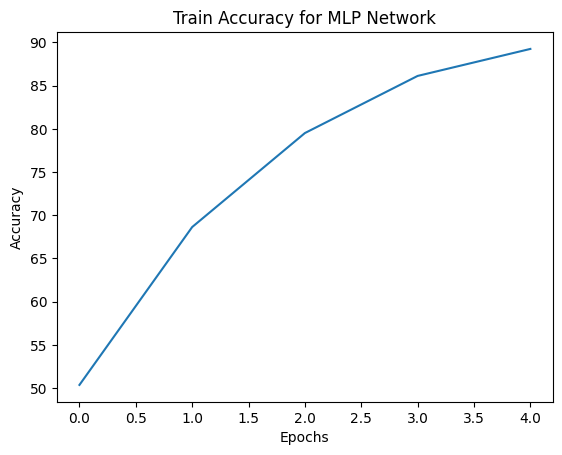

Text(0, 0.5, 'Accuracy')

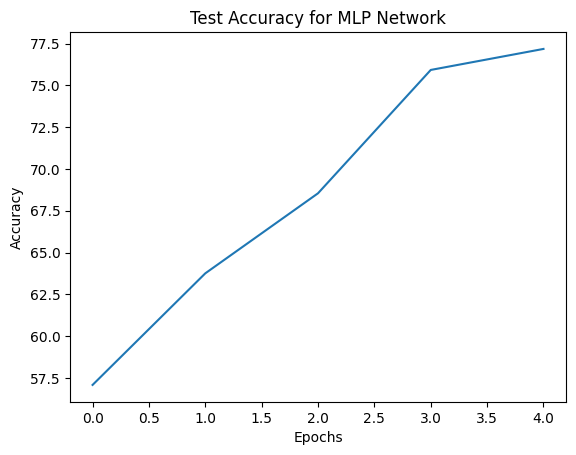

In [71]:
################## MLP

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()

        # In the LSTM network, unfurtonatley we will encounter with stucking in local minimum
        # To solve this problem, I tried different ways such as noise injecion, label smoothing,
        # consider a low batch_size, increasing the learning rate
        # But the best method for preventing from this problem was Batch Normalization
        # so, we use this technique here in MLP, too!

        self.fc = nn.Sequential(nn.Linear(37*284, 256),
                        nn.BatchNorm1d(256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.BatchNorm1d(32),
                        nn.ReLU(),
                        nn.Linear(32, 16),
                        nn.BatchNorm1d(16),
                        nn.ReLU(),
                        nn.Linear(16, 2),# We have 2 class, so the last dim is 2, this number could be one, and we define a threshold
                                # of 0.5 to compare the results with 0 and 1. But defining 2 dim is easier!
                       )

    def forward(self, x):
        x = self.fc(x)
        out = nn.functional.softmax(x,dim=1)# Use softmax, because the labels are 0 and 1
        # and softmax is the best activation function for the output layer

        return out

epochs=5

model = MLPModel().to(torch.float64)
model = to_device(model,device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


all_accs_train=[]
all_accs_test=[]
for epoch in range(epochs):
    acc = []
    i=0

    for inputs, labels in train_loader:

        i=i+1
        outputs = model.forward(inputs)
        _,predicted = torch.max(outputs,dim=1)
        acc.append(torch.sum(predicted == labels).item() / len(predicted))



        loss = criterion(outputs, labels)# use cross entropy loss function, because the task is classification
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    all_accs_train.append(100*np.mean(acc))
    print('MLP\nepoch',epoch+1,'\nTrain Loss is:',loss.item(),' Train Accuracy is:',100*np.mean(acc),"%")


    with torch.no_grad():
      acc=[]
      for inputs, labels_test in test_loader:

          outputs= model.forward(inputs)
          _, predicted_test = torch.max(outputs, dim=1)
          acc.append(torch.sum(predicted_test == labels_test).item() / len(predicted_test))
          loss = criterion(outputs, labels_test)
          optimizer.step()
          optimizer.zero_grad()
      all_accs_test.append(100*np.mean(acc))
      print('Test Loss is:', loss.item(), ' Test Accuracy is:', 100 * np.mean(acc), "%")

print("Real Labels for Train Data are:")
print(labels)

print("Predicted Labels for Train Data are:")
print(predicted)

print("Real Labels for Test Data are:")
print(labels_test)

print("Predicted Labels for Test Data are:")
print(predicted_test)

acc_train_MLP=all_accs_train[-1]
acc_test_MLP=all_accs_test[-1]


plt.plot(all_accs_train)
plt.title("Train Accuracy for MLP Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

plt.plot(all_accs_test)
plt.title("Test Accuracy for MLP Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


LSTM
epoch 1 
Train Loss is: 0.3914798940290865  Train Accuracy is: 78.96634615384616 %
Test Loss is: 0.37582345254177635  Test Accuracy is: 80.49186390532545 %
LSTM
epoch 2 
Train Loss is: 0.36183516863481735  Train Accuracy is: 83.53365384615384 %
Test Loss is: 0.2779591118818847  Test Accuracy is: 80.36242603550296 %
LSTM
epoch 3 
Train Loss is: 0.21872601646959422  Train Accuracy is: 85.9375 %
Test Loss is: 0.3845360645454679  Test Accuracy is: 81.50887573964496 %
LSTM
epoch 4 
Train Loss is: 0.28438489063673417  Train Accuracy is: 87.80048076923077 %
Test Loss is: 0.3713623524526671  Test Accuracy is: 82.47041420118344 %
LSTM
epoch 5 
Train Loss is: 0.18751492607065567  Train Accuracy is: 89.9639423076923 %
Test Loss is: 0.8042956314661945  Test Accuracy is: 81.04659763313609 %
Real Labels for Train Data are:
tensor([1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Predicted Labels for Train Data are:
tensor([1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Real Labels for Test Data are:
tensor

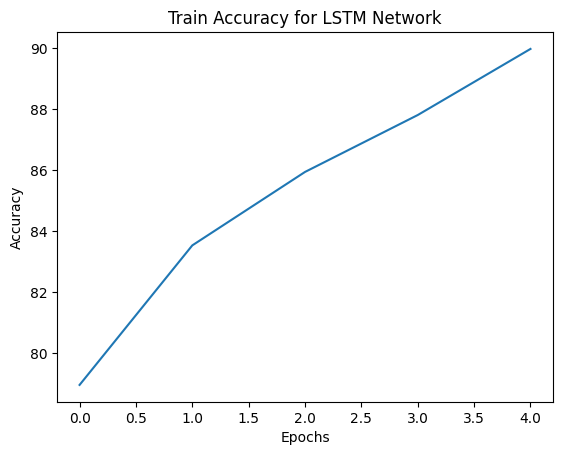

Text(0, 0.5, 'Accuracy')

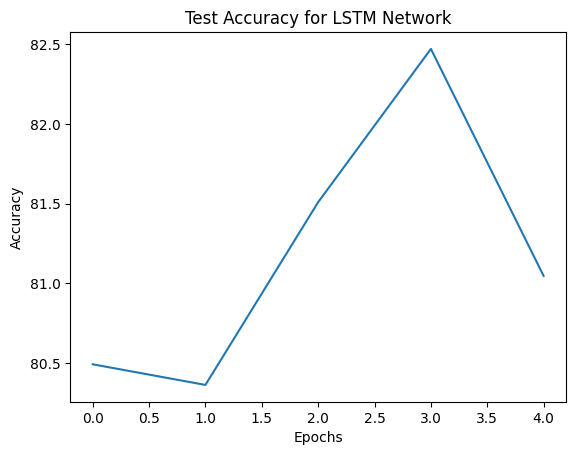

In [72]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        # We consider an LSTM network, and after that we will reshape the output of that
        # and pass it to an FC.
        # As I mentioned, this network suffers from getting stuck in local minimum
        # and to solve this problem, we used Batch Normalization

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.fc = nn.Sequential(nn.BatchNorm1d(37*hidden_size),
                        nn.Linear(37*hidden_size, 256),
                        nn.BatchNorm1d(256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.BatchNorm1d(32),
                        nn.ReLU(),
                        nn.Linear(32, 16),
                        nn.BatchNorm1d(16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                       )

    def forward(self, x,h,c):
        lstm_out,_= self.lstm(x,(h,c))

        lstm_out=torch.reshape(lstm_out,(len(lstm_out),-1))# flatten the output of LSTM according to the question file!

        out = self.fc(lstm_out)

        return out


input_size=len(characters)
hidden_size=256


model=LSTMModel(input_size,hidden_size).to(torch.float64)


criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(),lr=0.01)

model=model.to(device)

all_accs_train=[]
all_accs_test=[]
for epoch in range(epochs):

    acc=[]
    i=0


    for inputs, labels in train_loader:
        h = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        c = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        h=h.to(device)
        c=c.to(device)
        # We define h and c for LSTM ( as were explained in the class of Deep Learning)
        # where h is the output of the LSTM and c can handle the memory cell
        # we use them to implement the LSTM.


        i=i+1

        inputs2=inputs.reshape(len(inputs),the_max_length,-1)# For the LSTM we need to show the model the sequential form of the input
        # so, every token must be passed to the LSTM.
        outputs= model.forward(inputs2,h,c)

        _, predicted = torch.max(outputs, dim=1)
        acc.append(torch.sum(predicted == labels).item() / len(predicted))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    all_accs_train.append(100 * np.mean(acc))
    print('LSTM\nepoch', epoch+1, '\nTrain Loss is:', loss.item(), ' Train Accuracy is:', 100 * np.mean(acc), "%")

    with torch.no_grad():
      acc=[]

      i=0

      for inputs, labels_test in test_loader:

          h = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
          c = torch.randn(1,len(inputs),hidden_size).to(torch.float64)

          h=h.to(device)
          c=c.to(device)


          i=i+1

          inputs=inputs.to(device)
          labels_test=labels_test.to(device)
          inputs2=inputs.reshape(len(inputs),the_max_length,-1)


          outputs= model.forward(inputs2,h,c)

          _, predicted_test = torch.max(outputs, dim=1)

          acc.append(torch.sum(predicted_test == labels_test).item() / len(predicted_test))
          loss = criterion(outputs, labels_test)
          optimizer.step()
          optimizer.zero_grad()
      all_accs_test.append(100 * np.mean(acc))
      print('Test Loss is:', loss.item(), ' Test Accuracy is:', 100 * np.mean(acc), "%")

print("Real Labels for Train Data are:")
print(labels)

print("Predicted Labels for Train Data are:")
print(predicted)


print("Real Labels for Test Data are:")
print(labels_test)

print("Predicted Labels for Test Data are:")
print(predicted_test)

acc_train_LSTM=all_accs_train[-1]
acc_test_LSTM=all_accs_test[-1]


plt.plot(all_accs_train)
plt.title("Train Accuracy for LSTM Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

plt.plot(all_accs_test)
plt.title("Test Accuracy for LSTM Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


BiLSTM
epoch 1 
Train Loss is: 0.2826919421652512 Train Accuracy is: 75.60096153846155 %
Test Loss is: 0.5024640314664809  Test Accuracy is: 76.83062130177515 %
BiLSTM
epoch 2 
Train Loss is: 0.39782101904402134 Train Accuracy is: 77.70432692307693 %
Test Loss is: 0.5697312070722551  Test Accuracy is: 76.77514792899409 %
BiLSTM
epoch 3 
Train Loss is: 0.4533383820447009 Train Accuracy is: 81.43028846153845 %
Test Loss is: 0.3644108866886198  Test Accuracy is: 79.21597633136095 %
BiLSTM
epoch 4 
Train Loss is: 0.7931694660949297 Train Accuracy is: 83.65384615384616 %
Test Loss is: 0.3642052229567022  Test Accuracy is: 81.26849112426035 %
BiLSTM
epoch 5 
Train Loss is: 0.17376717479761844 Train Accuracy is: 86.17788461538461 %
Test Loss is: 0.24772271675017446  Test Accuracy is: 81.56434911242604 %
Real Labels for Train Data are:
tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted Labels for Train Data are:
tensor([1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Real Labels for Test Da

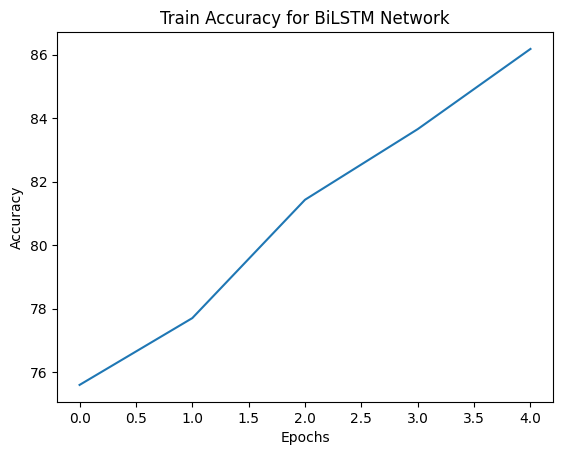

Text(0, 0.5, 'Accuracy')

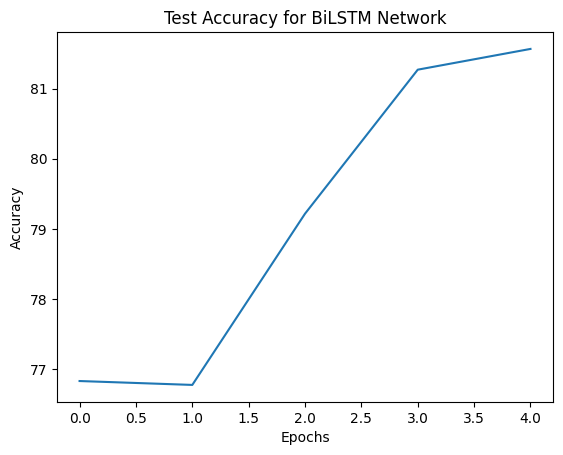

In [73]:

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.fc = nn.Sequential(nn.BatchNorm1d(37*2*hidden_size),
                        nn.Linear(37*2*hidden_size, 256),
                        nn.BatchNorm1d(256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.BatchNorm1d(128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.BatchNorm1d(32),
                        nn.ReLU(),
                        nn.Linear(32, 16),
                        nn.BatchNorm1d(16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                       )



    def forward(self, x,h1,c1,h2,c2):

        # BiLSTM is very similar to LSTM, the only difference is that we pass the model from the begining to ending
        # And also, we pass it from its end to its begin, so we have a causal approach which is identical to the LSTM
        # and we have an anti causal approach which is flipped of the previous way
        # then we can concat or add these two outputs and pass that to FC layer.

        lstm_causal,_= self.lstm(x,(h1,c1))


        lstm_anti_causal,_= self.lstm(torch.flip(x,dims=(1,)),(h2,c2))

        lstm_causal=torch.reshape(lstm_causal,(len(lstm_causal),-1))
        lstm_anti_causal=torch.reshape(lstm_anti_causal,(len(lstm_causal),-1))


        lstm_out=torch.concat((lstm_causal,lstm_anti_causal),dim=1)

        out = self.fc(lstm_out)

        return out

input_size = len(characters)
hidden_size = 256

model = BiLSTMModel(input_size, hidden_size).to(torch.float64)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model=model.to(device)

all_accs_train=[]
all_accs_test=[]
for epoch in range(epochs):
    acc = []
    i = 0

    for inputs, labels in train_loader:
        h1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        c1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        h2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        c2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)

        h1=h1.to(device)
        c1=c1.to(device)
        h2=h2.to(device)
        c2=c2.to(device)
        # Here we need to define two h and two c for BiLSTM, I think this can help the model more!

        inputs=inputs.to(device)
        labels=labels.to(device)
        i=i+1

        inputs2=inputs.reshape(len(inputs),the_max_length,-1)

        outputs= model.forward(inputs2,h1,c1,h2,c2)
        _, predicted = torch.max(outputs, dim=1)
        acc.append(torch.sum(predicted == labels).item() / len(predicted))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    all_accs_train.append(100 * np.mean(acc))
    print('BiLSTM\nepoch', epoch+1, '\nTrain Loss is:', loss.item(), 'Train Accuracy is:', 100 * np.mean(acc), "%")


    with torch.no_grad():
      acc=[]
      for inputs, labels_test in test_loader:
          h1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
          c1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
          h2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
          c2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)

          h1=h1.to(device)
          c1=c1.to(device)
          h2=h2.to(device)
          c2=c2.to(device)


          inputs=inputs.to(device)
          labels_test=labels_test.to(device)
          inputs2=inputs.reshape(len(inputs),the_max_length,-1)

          outputs= model.forward(inputs2,h1,c1,h2,c2)
          _, predicted_test = torch.max(outputs, dim=1)
          acc.append(torch.sum(predicted_test == labels_test).item() / len(predicted_test))
          loss = criterion(outputs, labels_test)
          optimizer.step()
          optimizer.zero_grad()
      all_accs_test.append(100 * np.mean(acc))
      print('Test Loss is:', loss.item(), ' Test Accuracy is:', 100 * np.mean(acc), "%")

print("Real Labels for Train Data are:")
print(labels)

print("Predicted Labels for Train Data are:")
print(predicted)


print("Real Labels for Test Data are:")
print(labels_test)

print("Predicted Labels for Test Data are:")
print(predicted_test)


acc_train_BiLSTM=all_accs_train[-1]
acc_test_BiLSTM=all_accs_test[-1]

plt.plot(all_accs_train)
plt.title("Train Accuracy for BiLSTM Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

plt.plot(all_accs_test)
plt.title("Test Accuracy for BiLSTM Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")


In [74]:
######## Comparing different accuracies:
print("Accuracy for train data using MLP network is: ",acc_train_MLP)
print("Accuracy for test data using MLP network is: ",acc_test_MLP)

print("Accuracy for train data using LSTM network is: ",acc_train_LSTM)
print("Accuracy for test data using LSTM network is: ",acc_test_LSTM)

print("Accuracy for train data using BiLSTM network is: ",acc_train_BiLSTM)
print("Accuracy for test data using BiLSTM network is: ",acc_test_BiLSTM)

Accuracy for train data using MLP network is:  89.24278846153845
Accuracy for test data using MLP network is:  77.1819526627219
Accuracy for train data using LSTM network is:  89.9639423076923
Accuracy for test data using LSTM network is:  81.04659763313609
Accuracy for train data using BiLSTM network is:  86.17788461538461
Accuracy for test data using BiLSTM network is:  81.56434911242604


In [25]:

########### CrossValidation for MLP and LSTM
batch_size=32

K=5# in Kfold, k is 5


# For this part, we need to split all the data to 5 folds
part_length=len(reshaped_data)//K
labels = p_np

reshaped_data_torch=torch.tensor(reshaped_data)
labels=np.array(labels,dtype=np.uint8)
labels_torch=torch.tensor(labels,dtype=torch.long)


packs_X=torch.zeros((K,part_length,np.shape(reshaped_data_torch)[1]))
packs_Y=torch.zeros((K,part_length))

# We call every split of the data "packs", we should consider packs for both of labels and smiles by using this simple "for"

for i in range(K):
    packs_X[i,:,:]=reshaped_data_torch[i*part_length:(i+1)*part_length,:]
    packs_Y[i,:]=torch.tensor(labels[i*part_length:(i+1)*part_length])



### CrossValidation for MLP


# All the codes is similar to the traditional MLP and the only difference is that we have to choose the test dataset,
# and consider all other data as train dataset
all_accs=np.zeros(K)
for k in range(K):
            test_array_X=packs_X[k,:,:]
            test_array_Y=packs_Y[k,:]

            test_array_X=torch.squeeze(test_array_X)
            test_array_Y=torch.squeeze(test_array_Y)

            train_array_X=torch.concat((packs_X[:k,:,:],packs_X[k+1:,:,:]),0)# considering all other data(except test data) as training dataset for smiles
            train_array_X=torch.reshape(train_array_X,(-1,train_array_X.shape[2]))# For MLP, we reshape the data

            train_array_Y=torch.concat((packs_Y[:k,:],packs_Y[k+1:,:]),0)# considering all other data(except test data) as training dataset for labels
            train_array_Y=torch.reshape(train_array_Y,(-1,train_array_X.shape[0]))# Reshaping the concatenated data for passing through the model
            train_array_Y=torch.squeeze(train_array_Y)

            train_dataset = SMILES_dataset(data=torch.tensor(train_array_X), labels=torch.tensor(train_array_Y))
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            train_loader = DeviceDataLoader(train_loader,device)

            test_dataset = SMILES_dataset(data=torch.tensor(test_array_X), labels=torch.tensor(test_array_Y))
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DeviceDataLoader(test_loader,device)


            print()
            print(50 * "#")
            print("K Fold Crossvalidation MLP; k is: ",k)

            model = MLPModel().to(torch.float32)
            model = to_device(model,device)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.0001)



            for epoch in range(epochs):
                acc = []
                i=0
                for inputs, labels in train_loader:
                    i=i+1
                    outputs = model.forward(inputs)
                    _,predicted = torch.max(outputs,dim=1)

                    acc.append(torch.sum(predicted == labels).item() / len(predicted))
                    loss=criterion(outputs,labels.long())
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()


            with torch.no_grad():
               acc=[]
               for inputs, labels in test_loader:

                   inputs=inputs.to(device)
                   labels=labels.to(device)
                   outputs= model.forward(inputs)
                   _, predicted = torch.max(outputs, dim=1)
                   acc.append(torch.sum(predicted == labels).item() / len(predicted))
                   loss = criterion(outputs, labels.long())
                   optimizer.step()
                   optimizer.zero_grad()

            all_accs[k]=np.mean(acc)
            print('MLP\nTest Loss is:', loss.item(), ' Test Accuracy for',k,'th fold is:', 100 * all_accs[k], "%")

print('Average accuracy is:',100*np.mean(all_accs))
print('Best accuracy is:',100*np.max(all_accs))

best_acc_MLP=np.max(all_accs)
average_acc_MLP=np.mean(all_accs)

<ipython-input-25-d33fc42e9997>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = SMILES_dataset(data=torch.tensor(train_array_X), labels=torch.tensor(train_array_Y))
<ipython-input-25-d33fc42e9997>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = SMILES_dataset(data=torch.tensor(test_array_X), labels=torch.tensor(test_array_Y))



##################################################
K Fold Crossvalidation MLP; k is:  0
MLP
Test Loss is: 0.6981820464134216  Test Accuracy for 0 th fold is: 53.05103550295858 %

##################################################
K Fold Crossvalidation MLP; k is:  1
MLP
Test Loss is: 0.6627050042152405  Test Accuracy for 1 th fold is: 67.71449704142012 %

##################################################
K Fold Crossvalidation MLP; k is:  2
MLP
Test Loss is: 0.5369629263877869  Test Accuracy for 2 th fold is: 83.06213017751479 %

##################################################
K Fold Crossvalidation MLP; k is:  3
MLP
Test Loss is: 0.5427013635635376  Test Accuracy for 3 th fold is: 82.3594674556213 %

##################################################
K Fold Crossvalidation MLP; k is:  4
MLP
Test Loss is: 0.6823659539222717  Test Accuracy for 4 th fold is: 64.5155325443787 %
Average accuracy is: 70.1405325443787
Best accuracy is: 83.06213017751479


In [26]:

### CrossValidation for LSTM

# All the parts are completely similar to Crossvalidation for MLP


all_accs=np.zeros(K)
for k in range(K):
            test_array_X=packs_X[k,:,:]
            test_array_Y=packs_Y[k,:]

            test_array_X=torch.squeeze(test_array_X)
            test_array_Y=torch.squeeze(test_array_Y)

            train_array_X=torch.concat((packs_X[:k,:,:],packs_X[k+1:,:,:]),0)
            train_array_X=torch.reshape(train_array_X,(-1,train_array_X.shape[2]))

            train_array_Y=torch.concat((packs_Y[:k,:],packs_Y[k+1:,:]),0)
            train_array_Y=torch.reshape(train_array_Y,(-1,train_array_X.shape[0]))
            train_array_Y=torch.squeeze(train_array_Y)

            train_dataset = SMILES_dataset(data=torch.tensor(train_array_X), labels=torch.tensor(train_array_Y))
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            train_loader = DeviceDataLoader(train_loader,device)

            test_dataset = SMILES_dataset(data=torch.tensor(test_array_X), labels=torch.tensor(test_array_Y))
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DeviceDataLoader(test_loader,device)

            print()
            print(50 * "#")
            print("K Fold Crossvalidation LSTM; k is: ",k)

            input_size=len(characters)
            hidden_size=256

            model=LSTMModel(input_size, hidden_size).to(torch.float64)

            model=model.to(torch.float32)
            criterion=nn.CrossEntropyLoss()

            optimizer=optim.Adam(model.parameters(), lr=0.01)

            model=model.to(device)
            for epoch in range(epochs):
                acc=[]
                i=0

                for inputs, labels in train_loader:
                    inputs=inputs.to(device)
                    labels=labels.to(device)
                    h = torch.randn(1,len(inputs),hidden_size).to(torch.float32)
                    c = torch.randn(1,len(inputs),hidden_size).to(torch.float32)

                    h=h.to(device)
                    c=c.to(device)

                    i=i+1

                    inputs2=inputs.reshape(len(inputs),the_max_length,-1)

                    outputs= model.forward(inputs2,h.to(device),c.to(device))
                    _, predicted = torch.max(outputs, dim=1)
                    acc.append(torch.sum(predicted == labels).item() / len(predicted))
                    loss = criterion(outputs, labels.long())
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            with torch.no_grad():
               acc=[]
               for inputs, labels in test_loader:
                   h = torch.randn(1,len(inputs),hidden_size).to(torch.float32)
                   c = torch.randn(1,len(inputs),hidden_size).to(torch.float32)

                   h=h.to(device)
                   c=c.to(device)

                   inputs=inputs.to(device)
                   labels=labels.to(device)
                   inputs2=inputs.reshape(len(inputs),the_max_length,-1)

                   outputs= model.forward(inputs2,h,c)
                   _, predicted = torch.max(outputs, dim=1)
                   acc.append(torch.sum(predicted == labels).item() / len(predicted))
                   loss = criterion(outputs, labels.long())
                   optimizer.step()
                   optimizer.zero_grad()
            all_accs[k]=np.mean(acc)
            print('LSTM\nTest Loss is:', loss.item(), ' Test Accuracy is:', 100 * all_accs[k], "%")


print('Average accuracy is:',np.mean(all_accs))
print('Best accuracy is:',np.max(all_accs))

best_acc_LSTM=np.max(all_accs)
average_acc_LSTM=np.mean(all_accs)


##################################################
K Fold Crossvalidation LSTM; k is:  0


<ipython-input-26-91350da98299>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = SMILES_dataset(data=torch.tensor(train_array_X), labels=torch.tensor(train_array_Y))
<ipython-input-26-91350da98299>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = SMILES_dataset(data=torch.tensor(test_array_X), labels=torch.tensor(test_array_Y))


LSTM
Test Loss is: 0.8529491424560547  Test Accuracy is: 55.15902366863905 %

##################################################
K Fold Crossvalidation LSTM; k is:  1
LSTM
Test Loss is: 1.0994460582733154  Test Accuracy is: 64.58949704142012 %

##################################################
K Fold Crossvalidation LSTM; k is:  2
LSTM
Test Loss is: 0.4266681969165802  Test Accuracy is: 82.8957100591716 %

##################################################
K Fold Crossvalidation LSTM; k is:  3
LSTM
Test Loss is: 0.49657419323921204  Test Accuracy is: 79.6042899408284 %

##################################################
K Fold Crossvalidation LSTM; k is:  4
LSTM
Test Loss is: 0.6663140058517456  Test Accuracy is: 79.34541420118344 %
Average accuracy is: 0.7231878698224852
Best accuracy is: 0.828957100591716


In [27]:
######## Comparing different accuracies:

print("Best Accuracy for test data using MLP network is: ",100*best_acc_MLP,"%")
print("Average Accuracy for test data using MLP network is: ",100*average_acc_MLP,"%")

print("Best Accuracy for test data using LSTM network is: ",100*best_acc_LSTM,"%")
print("Average Accuracy for test data using LSTM network is: ",100*average_acc_LSTM,"%")


Best Accuracy for test data using MLP network is:  83.06213017751479 %
Average Accuracy for test data using MLP network is:  70.1405325443787 %
Best Accuracy for test data using LSTM network is:  82.8957100591716 %
Average Accuracy for test data using LSTM network is:  72.31878698224851 %


**قسمت و**


فرمولهای شیمیایی مطرح شده، هم از ابتدا به انتها وابسته هستند و هم از انتها به ابتدا.

لذا شبکه های بی ال اس تی ام میتوانند عملکرد طبقه بندی آنها را بهبود ببخشند؛ زیرا این شبکه ها با در نظر گرفتن هر داده به صورت وان هات، یک دور توالی فرمول شیمیایی را از ابتدا تا انتهای آن بررسی میکنند و یک بار نیز از انتها تا ابتدا بررسی میکنند.  

**قسمت ز**

In [170]:
######################### Z

# For this part, we have to split the test data to different sizes
# But for train, we exactly, do the previous method.
batch_size=32


############# Train (Exactly the same as previous methods)




vectorized_data=[]
for i in range(len(all_unique_data)):
    all_tokens=np.zeros((the_max_length,len(characters)))
    vectorized_data.append(all_tokens)
    for j in range(len(all_unique_data[i])):

        for k in range(len(characters)):
            if (characters[k]==all_unique_data[i][j]):
                vectorized_data[i][j][k]=1




reshaped_data=np.reshape(vectorized_data,(2050,the_max_length*len(characters)))

labels = p_np

X_train, X_test, y_train, y_test = train_test_split(reshaped_data, labels, test_size=0.2, random_state=42)


class SMILES_dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels


    def __getitem__(self,index):
        return self.data[index,:], self.labels[index]

    def __len__(self):
        return len(self.labels)

train_dataset=SMILES_dataset(data=X_train,labels=y_train)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader=DeviceDataLoader(train_loader,device)





############# Test Data

# This part of test is still identical to previous methods.
all_unique_data=[]
for k in range(len(smiles)):

    symbols = []
    current_symbol = smiles[k][0]
    i = 1
    while i < len(smiles[k]):
        char = smiles[k][i]
        if char.isupper() or char in ['[',']','(',')','=','0','1','2','3','4','5','6','7','8','9',"'\'",'/']:
            symbols.append(current_symbol)
            current_symbol = char
        elif char == '@':
            current_symbol += char + smiles[k][i+1:i+2]
            i += 2
        else:
            current_symbol += char
        i += 1
    symbols.append(current_symbol)

    unique_data = set()

    for item in symbols:
        unique_data.add(item)

    unique_data = list(unique_data)

    all_unique_data.append(unique_data)


unique_set = set(value for sublist in all_unique_data for value in sublist)

characters = sorted(list(unique_set))



# But this time is a bit different and we don't use padding, so we append all the data to lengthes. Thus,
# they will not necessary have equal sizes

lengthes=[]
vectorized_data=[]
for i in range(len(all_unique_data)):
    all_tokens=np.zeros((len(all_unique_data[i]),len(characters)))

    vectorized_data.append(all_tokens)
    lengthes.append(len(all_unique_data[i]))
    for j in range(len(all_unique_data[i])):

        for k in range(len(characters)):
            if (characters[k]==all_unique_data[i][j]):
                vectorized_data[i][j][k]=1






In [171]:

################################### Constructing the bins


# We should consider a non- uniform distribution for putting them on the bins.

# In fact, first, we sort the lengthes and consider the sum of them, then we device the sum on the number of bins
# and then according to them we construct the bins


sorted_lengthes=np.sort(lengthes)
sum_of_lengthes=np.sum(sorted_lengthes)


s=0
num_bins=10

values=np.linspace(0,sum_of_lengthes,num_bins+1)

length_for_intervals=np.zeros(num_bins+1,dtype=np.uint8)
for i in range(len(sorted_lengthes)):
  s=s+sorted_lengthes[i]
  for k in range(0,num_bins-1):
    if(s>= values[k] and s<values[k+1] ):# picking the end of intervals
      length_for_intervals[k]=sorted_lengthes[i]

length_for_intervals[-1]=sorted_lengthes[-1]
length_for_intervals=np.sort(length_for_intervals)

print("End length of every interval is",length_for_intervals)
split_arrays=[]

# Now we could find the end lengthes, it is time to construct all the lengthes between these ends.



for i in range (num_bins):
  split_arrays.append(np.linspace(length_for_intervals[i]+1,length_for_intervals[i+1],length_for_intervals[i+1]-length_for_intervals[i],dtype=np.uint8))



print("\n\nThe intevrals are:")

for i in range(len(split_arrays)):
  print(split_arrays[i])


labels=p_np
vectorized_data_numpy=np.array(vectorized_data)

_, X_test, _, y_test = train_test_split(vectorized_data_numpy, labels, test_size=0.2, random_state=42)



X_test2=[]
y_test2=[]
# We construct some hollow lists and be will fill them with the test data

for kk in range(num_bins):
    X_test2.append([])
    y_test2.append([])


for i in range(len(X_test)):
    for k in range(len(split_arrays)):
        # We check all the splits, so we put the suitable test data according to its length, in the bins.
        if (X_test[i].shape[0] in split_arrays[k]):
           X_test2[k].append(X_test[i])
           y_test2[k].append(y_test[i])


End length of every interval is [ 0  8 10 11 12 14 15 16 17 19 37]


The intevrals are:
[1 2 3 4 5 6 7 8]
[ 9 10]
[11]
[12]
[13 14]
[15]
[16]
[17]
[18 19]
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


<ipython-input-171-bdc21891c741>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vectorized_data_numpy=np.array(vectorized_data)


In [172]:
########### MLP Model

# This part is completely identical to the previous parts


model = MLPModel().to(torch.float64)
model = to_device(model,device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


all_accs_train=[]

for epoch in range(epochs):
    acc = []
    i=0

    for inputs, labels in train_loader:

        i=i+1
        outputs = model.forward(inputs)
        _,predicted = torch.max(outputs,dim=1)
        acc.append(torch.sum(predicted == labels).item() / len(predicted))


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    all_accs_train.append(100*np.mean(acc))
    print('MLP\nepoch',epoch+1,'\nTrain Loss is:',loss.item(),' Train Accuracy is:',100*np.mean(acc),"%")



MLP
epoch 1 
Train Loss is: 0.6617092698258458  Train Accuracy is: 77.2235576923077 %
MLP
epoch 2 
Train Loss is: 0.5134997177360525  Train Accuracy is: 83.17307692307693 %
MLP
epoch 3 
Train Loss is: 0.4981003495900397  Train Accuracy is: 88.22115384615384 %
MLP
epoch 4 
Train Loss is: 0.6269115571211169  Train Accuracy is: 91.22596153846155 %
MLP
epoch 5 
Train Loss is: 0.5104087774373112  Train Accuracy is: 93.0889423076923 %


MLP
Loss is: 0.5036631298202432  Accuracy is: 87.08333333333333 %
MLP
Loss is: 0.4989104957667473  Accuracy is: 88.54166666666666 %
MLP
Loss is: 0.6199373856729464  Accuracy is: 80.625 %
MLP
Loss is: 0.5670767728740443  Accuracy is: 80.0 %
MLP
Loss is: 0.4811915753285763  Accuracy is: 84.375 %
MLP
Loss is: 0.6446339060072291  Accuracy is: 63.21022727272727 %
MLP
Loss is: 0.5564969195942268  Accuracy is: 79.16666666666666 %
MLP
Loss is: 0.67157482540746  Accuracy is: 69.23076923076923 %
MLP
Loss is: 0.6097676695157345  Accuracy is: 71.42857142857143 %
MLP
Loss is: 0.8076878018135544  Accuracy is: 33.33333333333333 %
Average accuracy for all beans: 73.69945679320679


Text(0, 0.5, 'Accuracy')

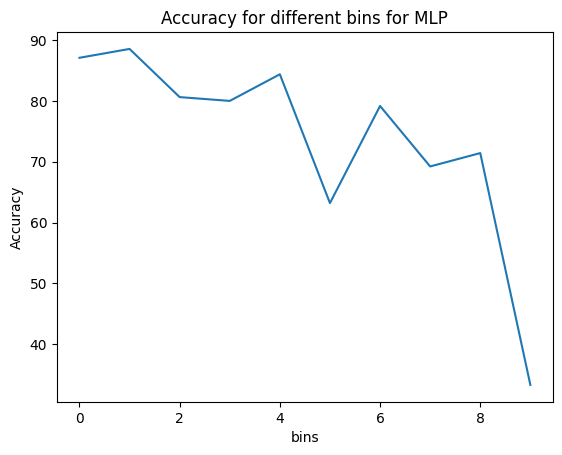

In [173]:


accs_for_bins=[]
for k in range(num_bins):
    Xteeeeest=X_test2[k]# Select the bin
    Yteeeeest=y_test2[k]# Select the bin

    # Now we have to change the tensor and use padding
    # Note that in my opinion, we MUST use padding here, because we trained the model with non equal input sizes and made them equal by using padding
    # Also, if we use non equal sizes, we cannot load data from the data loader!

    # So we consider the largest length for all, and we fill this tensor with our test data.

    tensored_Xteeeeest=torch.zeros((len(Xteeeeest),the_max_length,len(characters))).to(device)# The largest length is the_max_length which is 37


    for i in range(len(Xteeeeest)):
        tensored_Xteeeeest[i,:len(Xteeeeest[i]),:]=torch.tensor(Xteeeeest[i])


    # Now we can construct the test data loader again

    test_dataset = SMILES_dataset(data=tensored_Xteeeeest, labels=Yteeeeest)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DeviceDataLoader(test_loader,device)



    with torch.no_grad():
       acc=[]
       for inputs, labels in test_loader:
           inputs=inputs.to(device)
           labels=labels.to(device)



           inputs=torch.reshape(inputs,(len(inputs),the_max_length*len(characters)))
           outputs= model.forward(inputs.to(torch.float64))

           _, predicted = torch.max(outputs, dim=1)
           acc.append(torch.sum(predicted == labels).item() / len(predicted))
           loss = criterion(outputs, labels)
           optimizer.step()
           optimizer.zero_grad()
       accs_for_bins.append(100 *np.mean(acc))
       print('MLP\nLoss is:', loss.item(), ' Accuracy is:', accs_for_bins[-1], "%")



print('Average accuracy for all beans:',np.mean(accs_for_bins))
acc_test_MLP=accs_for_bins

plt.plot(accs_for_bins)
plt.title("Accuracy for different bins for MLP")
plt.xlabel("bins")
plt.ylabel("Accuracy")

In [174]:
########### BiLSTMModel Model

# This part is completely identical to previous parts


input_size = len(characters)
hidden_size = 256


model = BiLSTMModel(input_size, hidden_size).to(torch.float64)


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

model=model.to(device)
for epoch in range(epochs):
    acc = []
    i=0

    for inputs, labels in train_loader:
        h1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        c1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        h2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
        c2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)

        h1=h1.to(device)
        c1=c1.to(device)
        h2=h2.to(device)
        c2=c2.to(device)

        inputs=inputs.to(device)
        labels=labels.to(device)
        i=i+1

        inputs2=inputs.reshape(len(inputs),the_max_length,-1)
        outputs= model.forward(inputs2.to(torch.float64),h1,c1,h2,c2)

        _, predicted = torch.max(outputs, dim=1)
        acc.append(torch.sum(predicted == labels).item() / len(predicted))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print('BiLSTM\nepoch', epoch+1, '\nTrain Loss is:', loss.item(), ' Train Accuracy is:', 100 * np.mean(acc), "%")



BiLSTM
epoch 1 
Train Loss is: 0.31116627593522816  Train Accuracy is: 79.20673076923077 %
BiLSTM
epoch 2 
Train Loss is: 0.7677772485860345  Train Accuracy is: 84.01442307692307 %
BiLSTM
epoch 3 
Train Loss is: 0.361579277889784  Train Accuracy is: 87.13942307692307 %
BiLSTM
epoch 4 
Train Loss is: 0.9673323023183688  Train Accuracy is: 89.0625 %
BiLSTM
epoch 5 
Train Loss is: 1.128139203199114  Train Accuracy is: 88.76201923076923 %


LSTM
Loss is: 0.5262810327909888  Accuracy is: 82.6086956521739 %
LSTM
Loss is: 0.37454997304410276  Accuracy is: 86.25 %
LSTM
Loss is: 0.4531097423859023  Accuracy is: 83.78378378378379 %
LSTM
Loss is: 0.4281958765717524  Accuracy is: 88.0 %
LSTM
Loss is: 0.5155484769480333  Accuracy is: 79.22077922077922 %
LSTM
Loss is: 0.7242167035645711  Accuracy is: 69.76744186046511 %
LSTM
Loss is: 0.33814334453381684  Accuracy is: 87.5 %
LSTM
Loss is: 1.0220672276740037  Accuracy is: 61.53846153846154 %
LSTM
Loss is: 1.1847401430589077  Accuracy is: 47.61904761904761 %
LSTM
Loss is: 1.3176019853870653  Accuracy is: 47.61904761904761 %
Average accuracy for all beans: 73.39072572937587


Text(0, 0.5, 'Accuracy')

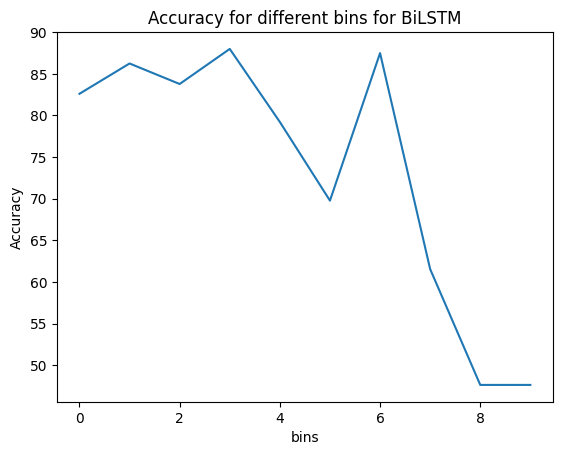

In [175]:

# This part is identical to MLP part for different test datasets.


accs_for_bins=[]
for k in range(num_bins):
    Xteeeeest=X_test2[k]
    Yteeeeest=y_test2[k]
    tensored_Xteeeeest=torch.zeros((len(Xteeeeest),the_max_length,len(characters))).to(device)


    for i in range(len(Xteeeeest)):
        tensored_Xteeeeest[i,:len(Xteeeeest[i]),:]=torch.tensor(Xteeeeest[i])



    test_dataset = SMILES_dataset(data=tensored_Xteeeeest, labels=Yteeeeest)
    test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)
    test_loader = DeviceDataLoader(test_loader,device)

    with torch.no_grad():
       acc=[]
       for inputs, labels in test_loader:
           h1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
           c1 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
           h2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)
           c2 = torch.randn(1,len(inputs),hidden_size).to(torch.float64)

           h1=h1.to(device)
           c1=c1.to(device)
           h2=h2.to(device)
           c2=c2.to(device)


           inputs=inputs.to(device)
           labels=labels.to(device)

           inputs2=inputs.reshape(len(inputs),the_max_length,-1)

           outputs= model.forward(inputs2.to(torch.float64),h1,c1,h2,c2)
           _, predicted = torch.max(outputs, dim=1)
           acc.append(torch.sum(predicted == labels).item() / len(predicted))
           loss = criterion(outputs, labels)
           optimizer.step()
           optimizer.zero_grad()

           accs_for_bins.append(100 *np.mean(acc))
       print('LSTM\nLoss is:', loss.item(), ' Accuracy is:', accs_for_bins[-1], "%")


acc_test_BiLSTM=accs_for_bins
print('Average accuracy for all beans:',np.mean(accs_for_bins))

plt.plot(accs_for_bins)
plt.title("Accuracy for different bins for BiLSTM")
plt.xlabel("bins")
plt.ylabel("Accuracy")

In [185]:

print("Accuracy for test data for different bins using MLP network is:\n ",acc_test_MLP)

print("Accuracy for test data for different bins using BiLSTM network is:\n ",acc_test_BiLSTM)
print("\n\n")


print("The First accuracy for MLP is:", acc_test_MLP[0])
print("The First accuracy for BiLSTM is:",acc_test_BiLSTM[0])

print("\n\n")

print("The Last accuracy for MLP is:", acc_test_MLP[-1])
print("The Last accuracy for BiLSTM is:",acc_test_BiLSTM[-1])


Accuracy for test data for different bins using MLP network is:
  [87.08333333333333, 88.54166666666666, 80.625, 80.0, 84.375, 63.21022727272727, 79.16666666666666, 69.23076923076923, 71.42857142857143, 33.33333333333333]
Accuracy for test data for different bins using BiLSTM network is:
  [82.6086956521739, 86.25, 83.78378378378379, 88.0, 79.22077922077922, 69.76744186046511, 87.5, 61.53846153846154, 47.61904761904761, 47.61904761904761]



The First accuracy for MLP is: 87.08333333333333
The First accuracy for BiLSTM is: 82.6086956521739



The Last accuracy for MLP is: 33.33333333333333
The Last accuracy for BiLSTM is: 47.61904761904761


میدانیم که در یک شبکه سکونشال، ارتباط مکانی(یا زمانی)  نمونه ها بررسی میشود. لذا از این جهت، نسبت به شبکه های ام ال پی برتری دارند که این اتفاق را برای بین های نهایی شاهد هستیم.




بنابراین اگر طول ورودی بسیار زیاد باشد، شبکه های ال اس تی ام و یا بی ال اس تی ام میتوانند بهتر از ام ال پی عمل کنند. اما هنگامی که طول ورودی کم است، شبکه های ام ال پی بهتر عمل خواهند کرد. زیرا شبکه های ال اس تی ام، در این صورت ممکن است دچار اوورفیتینگ شوند چون داده ی موجود، برای بین های اول، بسیار کم حجم است و نیازی به استفاده از یک شبکه ال اس تی ام برای ترین کردن آن نمیباشد و استفاده از ال اس تی ام به پرفورمنس شبکه نمیتواند کمک خاصی کند..